# Speedtest Data (`ScatterplotLayer`)

This example will use data collected from Ookla's Speed Test application and [shared publicly in the AWS Open Data Registry](https://registry.opendata.aws/speedtest-global-performance/). From the AWS page:

> Global fixed broadband and mobile (cellular) network performance, allocated to zoom level 16 web mercator tiles (approximately 610.8 meters by 610.8 meters at the equator). Data is provided in both Shapefile format as well as Apache Parquet with geometries represented in Well Known Text (WKT) projected in EPSG:4326. Download speed, upload speed, and latency are collected via the Speedtest by Ookla applications for Android and iOS and averaged for each tile.

You can view a [hosted version of this notebook on Notebook Sharing Space](https://notebooksharing.space/view/2c2fc0b1ef5f93c70a8c36de30b560d1316d16760714742dcf22a119f4991762#displayOptions=) (35MB download).

## Imports

In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from palettable.colorbrewer.diverging import BrBG_10

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

## Fetch data



The URL for a single data file for mobile network speeds in the first quarter of 2019:

In [2]:
url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2019/quarter=1/2019-01-01_performance_mobile_tiles.parquet"

The data used in this example is relatively large. In the cell below, we cache the downloading and preparation of the dataset so that it's faster to run this notebook the second time.

We fetch two columns — `avg_d_kbps` and `tile` — from this data file directly from AWS. The `pd.read_parquet` command will perform a network request for these columns from the data file, so it may take a while on a slow network connection. `avg_d_kbps` is the average download speed for that data point in kilobits per second. `tile` is the WKT string representing a given zoom-16 Web Mercator tile.

The `tile` column contains _strings_ representing WKT-formatted geometries. We need to parse those strings into geometries. Then for simplicity we'll convert into their centroids.

In [3]:
local_path = Path("internet-speeds.parquet")
if local_path.exists():
    gdf = gpd.read_parquet(local_path)
else:
    columns = ["avg_d_kbps", "tile"]
    df = pd.read_parquet(url, columns=columns)

    tile_geometries = shapely.from_wkt(df["tile"])
    tile_centroids = shapely.centroid(tile_geometries)
    gdf = gpd.GeoDataFrame(df[["avg_d_kbps"]], geometry=tile_centroids, crs='EPSG:4326')
    gdf.to_parquet(local_path)

We can take a quick look at this data:

In [4]:
gdf.head()

,avg_d_kbps,geometry
0,5983,POINT (-160.01862 70.63722)
1,3748,POINT (-160.04059 70.63357)
2,3364,POINT (-160.04059 70.63175)
3,2381,POINT (-160.03510 70.63357)
4,3047,POINT (-160.03510 70.63175)


To ensure that this demo is snappy on most computers, we'll filter to a bounding box over Europe.

If you're on a recent computer, feel free to comment out the next line.

In [5]:
gdf = gdf.cx[-11.83:25.5, 34.9:59]

Even this filtered data frame still has 800,000 rows, so it's still a lot of data to explore:

In [6]:
gdf

,avg_d_kbps,geometry
0,5983,POINT (-160.01862 70.63722)
1,3748,POINT (-160.04059 70.63357)
2,3364,POINT (-160.04059 70.63175)
3,2381,POINT (-160.03510 70.63357)
4,3047,POINT (-160.03510 70.63175)
...,...,...
3231240,19528,POINT (169.81842 -46.29571)
3231241,15693,POINT (169.81293 -46.30710)
3231242,26747,POINT (169.66461 -46.42082)
3231243,67995,POINT (169.65912 -46.45110)


To render point data, first create a `ScatterplotLayer` and then add it to a `Map` object:

In [7]:
layer = ScatterplotLayer.from_geopandas(gdf)
m = Map(layer)
m

Map(layers=[ScatterplotLayer(table=pyarrow.Table
avg_d_kbps: uint32
geometry: fixed_size_list<item: double>[2]…

We can look at the [documentation for `ScatterplotLayer`](https://developmentseed.org/lonboard/latest/api/layers/scatterplot-layer/) to see what other rendering options it allows. Let's set the fill color to something other than black:

In [8]:
layer.get_fill_color = [0, 0, 200, 200]

Blue is pretty, but the map would be more informative if we colored each point by a relevant characteristic. In this case, we have the download speed associated with each location, so let's use that!

Here we compute a linear statistic for the download speed. Given a minimum bound of `5000` and a maximum bound of `50,000` the normalized speed is linearly scaled to between 0 and 1.

In [9]:
min_bound = 5000
max_bound = 50000
download_speed = gdf['avg_d_kbps']
normalized_download_speed = (download_speed - min_bound) / (max_bound - min_bound)

`normalized_download_speed` is now linearly scaled based on the bounds provided above. Keep in mind that the **input range of the colormap is 0-1**. So any values that are below 0 will receive the left-most color in the colormap, while any values above 1 will receive the right-most color in the colormap.

In [10]:
normalized_download_speed

0          0.021844
1         -0.027822
2         -0.036356
3         -0.058200
4         -0.043400
             ...   
3231240    0.322844
3231241    0.237622
3231242    0.483267
3231243    1.399889
3231244   -0.083778
Name: avg_d_kbps, Length: 3231245, dtype: float64

We can use any colormap provided by the [`palettable`](https://github.com/jiffyclub/palettable) package. Let's inspect the `BrBG_10` diverging colormap below:

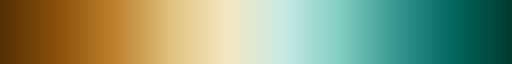

In [11]:
BrBG_10.mpl_colormap

Now let's apply the colormap on `normalized_download_speed` using a helper provided by `lonboard`. We can set it on `layer.get_fill_color` to update the existing colors.

In [12]:
layer.get_fill_color = apply_continuous_cmap(normalized_download_speed, BrBG_10, alpha=0.7)

After running the above cell, you should see the map above update with a different color per point!

We can pass an array into any of the "accessors" supported by the layer (this is any attribute that starts with `get_*`).

For demonstration purposes, let's also set `get_radius` to `normalized_download_speed`.

In [13]:
layer.get_radius = normalized_download_speed * 200
layer.radius_units = "meters"
layer.radius_min_pixels = 0.5

After running the above cell, you should see the map updated to have a different radius per point!